In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
%ls '/kaggle/input/'

Meta/  Meta.csv  Test/  Test.csv  Train/  Train.csv  meta/  test/  train/


In [4]:
print(pd.read_csv('/kaggle/input/Train.csv').head())

   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  


In [5]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
import time
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

train_trans = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
#     transforms.ColorJitter(brightness=0.6, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
#     transforms.Resize((128,128)),
])


class TrafficSignDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir  # root of images
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_rel_path = self.data.iloc[idx]['Path']
        img_path = os.path.join(self.img_dir, img_rel_path.lstrip())  
        image = Image.open(img_path).convert('RGB')
        label = int(self.data.iloc[idx]['ClassId'])
        if self.transform:
            image = self.transform(image)
        return image, label

data_train = TrafficSignDataset(
    csv_file='/kaggle/input/Train.csv',
    img_dir='/kaggle/input/',
    transform=train_trans
)

dataloader_train = DataLoader(
    data_train,
    shuffle=True,
    batch_size=64,
    num_workers=2
)

Using device: cuda


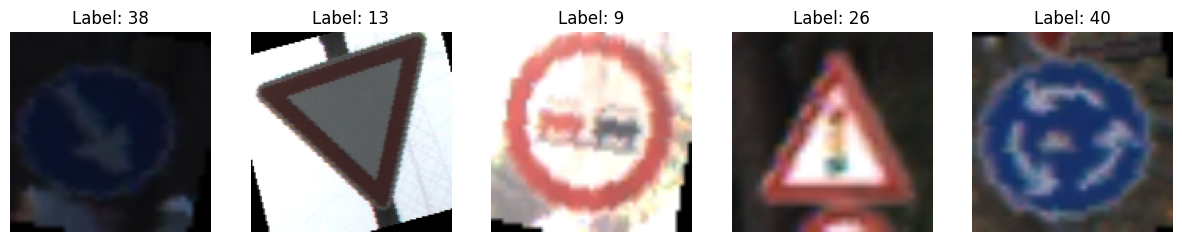

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of data
images, labels = next(iter(dataloader_train))

# Plot images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for idx in range(5):
    ax = axes[idx]
    img = np.transpose(images[idx], (1, 2, 0))
    ax.imshow(img)
    ax.set_title(f'Label: {labels[idx].item()}')
    ax.axis('off')
plt.show()

In [7]:
import torch.nn as nn

class TrafficSign(nn.Module):
    def __init__(self, num_classes):
        super(TrafficSign, self).__init__()
        

        self.feature_extractor = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),  
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),  
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.25),
            
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),  
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.25),
            

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),  
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.25),
            
            nn.Flatten()
        )
        

        self.classifier = nn.Sequential(
            nn.Linear(256 * 8 * 8, 128),  
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [ ]:
ts = TrafficSign(num_classes = 43).to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ts.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
ts.train()
# start_time = time.time()
for epoch in range(20):
    running_loss = 0.0

    for images, labels in dataloader_train:
        images , labels = images.to('cuda') , labels.to('cuda')
        optimizer.zero_grad()
        outputs = ts(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss/len(dataloader_train)
    print(f'Epoch {epoch + 1} loss is {epoch_loss:.4f}')
    scheduler.step()
    
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': ts.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, '/kaggle/working/checkpoint.pth')
        print(f"Checkpoint saved at epoch {epoch + 1}")
        
# end_time = time.time()
# epoch_duration = end_time - start_time
# print(f"Time taken for 1 epoch: {epoch_duration:.2f} seconds")

In [12]:

checkpoint = torch.load('/kaggle/working/checkpoint.pth')

ts = TrafficSign(num_classes=43).to('cuda')
optimizer = optim.Adam(ts.parameters(), lr=1e-3)

ts.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

epoch = checkpoint['epoch']
loss = checkpoint['loss']

print(f"Model loaded from epoch {epoch + 1} with loss {loss:.4f}")

Model loaded from epoch 20 with loss 0.2507


/tmp/ipykernel_36/3866381076.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/working/checkpoint.pth')


In [8]:
print(pd.read_csv('/kaggle/input/Test.csv').head())

   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48      52       6       6      43      47       38  Test/00002.png
3     27      29       5       5      22      24       33  Test/00003.png
4     60      57       5       5      55      52       11  Test/00004.png


In [9]:
from PIL import Image

class TestDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['Path']  
        img_path = os.path.join(self.img_dir, img_name) # NB drop the test in the img_dir because of how path is inputted
        image = Image.open(img_path).convert('RGB')
        
        label = self.data.iloc[idx]['ClassId']  
        
        if self.transform:
            image = self.transform(image)
        
        return image, label 

In [10]:
test_trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128))
])

dataset_test = TestDataset(
    csv_file = '/kaggle/input/Test.csv',
    img_dir='/kaggle/input/',
    transform= test_trans
)

dataloader_test = DataLoader(
    dataset_test,
    shuffle = False,
    batch_size = 64
)

#change dataloader batch size to 1 before running 
# image, label = next(iter(dataloader_test))
# # print(image.shape)
# # image = image.squeeze().permute(1,2,0)
# # print(image.shape)
# # plt.imshow(image)
# # plt.show()
# print(label)

Precision:0.96
Accuracy:0.94
Recall:0.94


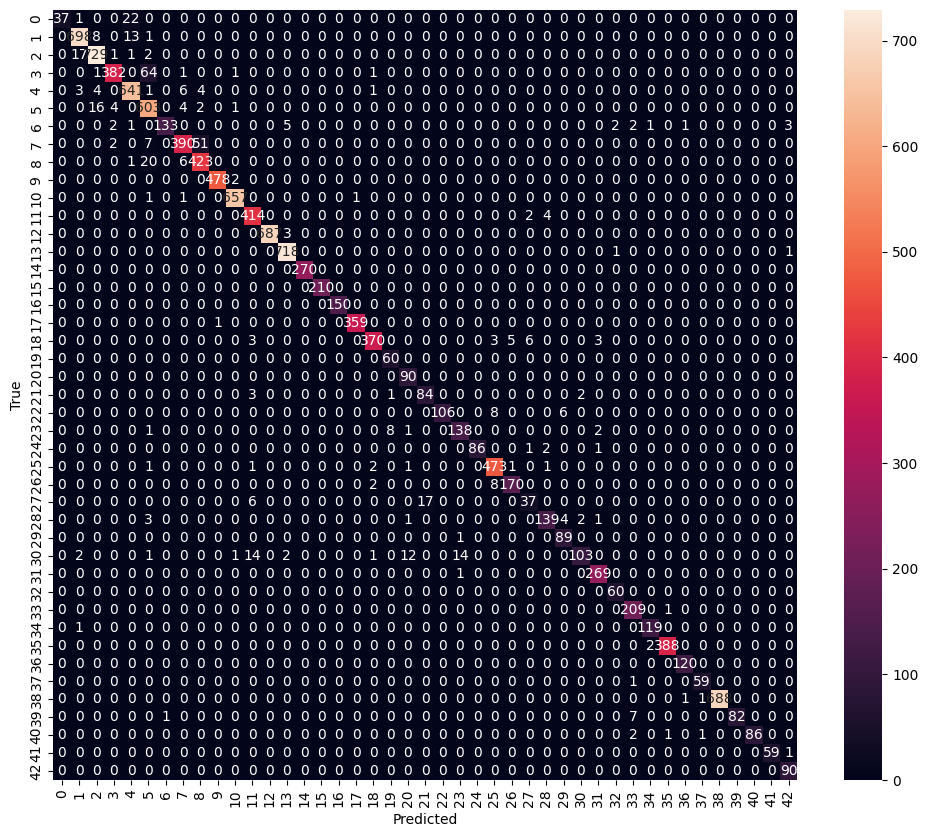

              precision    recall  f1-score   support

           0       1.00      0.62      0.76        60
           1       0.97      0.97      0.97       720
           2       0.96      0.97      0.97       750
           3       0.98      0.85      0.91       450
           4       0.94      0.97      0.96       660
           5       0.86      0.96      0.90       630
           6       0.99      0.89      0.94       150
           7       0.96      0.87      0.91       450
           8       0.88      0.94      0.91       450
           9       1.00      1.00      1.00       480
          10       0.99      1.00      0.99       660
          11       0.94      0.99      0.96       420
          12       1.00      1.00      1.00       690
          13       0.99      1.00      0.99       720
          14       1.00      1.00      1.00       270
          15       1.00      1.00      1.00       210
          16       1.00      1.00      1.00       150
          17       1.00    

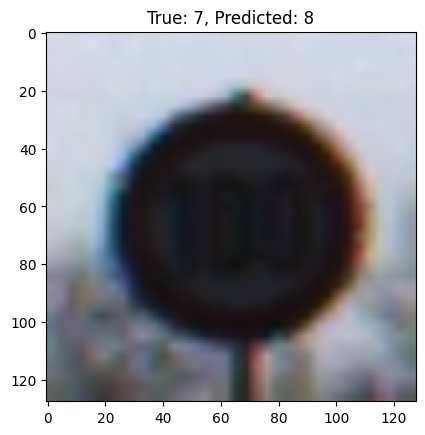

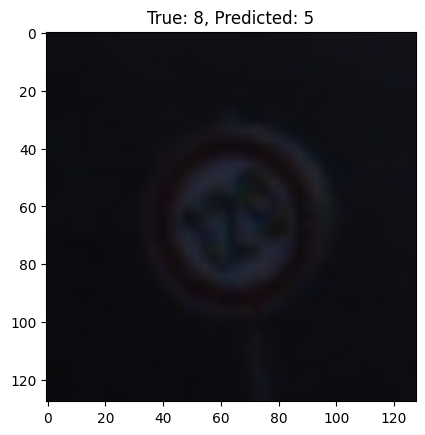

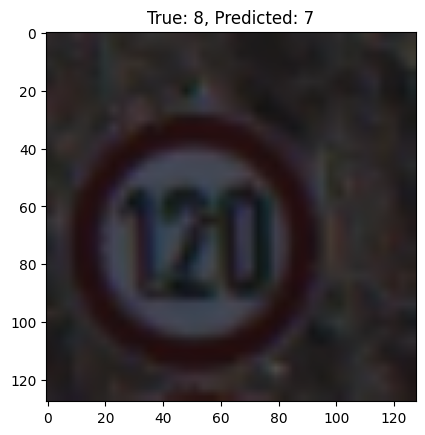

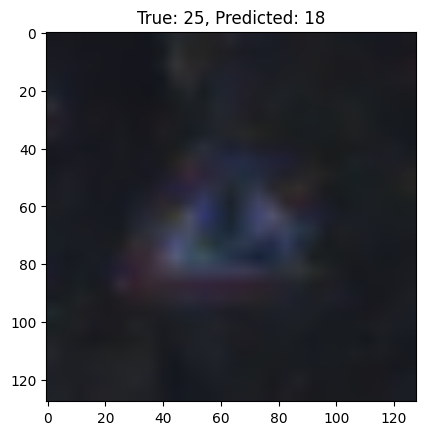

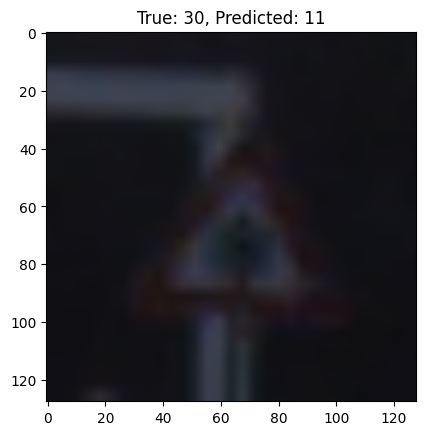

In [13]:
from torchmetrics import Accuracy, Precision, Recall
from sklearn.metrics import confusion_matrix , classification_report
import seaborn as sns
recall = Recall(task='multiclass', num_classes=43, average='macro').to('cuda')
accuracy = Accuracy(task='multiclass', num_classes=43, average='macro').to('cuda')
precision = Precision(task='multiclass', num_classes=43, average='macro').to('cuda')

true_labels = []
pred_labels = []

ts.eval()

with torch.no_grad():
    for images, labels in dataloader_test:
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = ts(images)
        _, preds = torch.max(outputs,1)
        precision(preds, labels)
        accuracy(preds, labels)
        recall(preds, labels)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

ts_precision = precision.compute()
ts_accuracy = accuracy.compute()
ts_recall = recall.compute()

print(f'Precision:{ts_precision:.2f}\nAccuracy:{ts_accuracy:.2f}\nRecall:{ts_recall:.2f}')

cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

report = classification_report(true_labels, pred_labels)
print(report)

misclassified = []
for i in range(len(true_labels)):
    if true_labels[i] != pred_labels[i]:
        misclassified.append((i, true_labels[i], pred_labels[i]))

for idx, true_label, pred_label in misclassified[:5]:
    img, _ = dataset_test[idx]
    img = img.cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    plt.title(f'True: {true_label}, Predicted: {pred_label}')
    plt.show()

In [15]:
total_params = sum(p.numel() for p in ts.parameters())

trainable_params = sum(p.numel() for p in ts.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 2492203
Trainable parameters: 2492203
